In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import fitsio
from astropy.table import Table
import legacyhalos

rc = {'font.family': 'serif'}
palette, context = 'Set2', 'talk'

sns.set(context=context, style='ticks', font_scale=1.2, rc=rc)
sns.set_palette(palette, 12)

colors = sns.color_palette()
#sns.reset_orig()

test_path = '/Users/matt/Data/legacydata/sv3-clustering/test_results/39627865741856956'

In [11]:
from legacyhalos.sv3 import get_cosmology
cosmo = get_cosmology()

In [12]:
def _sbprofile_colors(makeiter=True, galex=False, unwise=False):
    """Return an iterator of colors good for the surface brightness profile plots.
    https://seaborn.pydata.org/generated/seaborn.color_palette.html#seaborn.color_palette

    """
    try:
        _colors = sns.color_palette('Set1', n_colors=14, desat=0.75)
    except:
        _colors = ['red', 'green', 'blue', 'orange', 'purple']
        
    sbcolors = [_colors[1], _colors[2], _colors[0]]
    colorcolors = [_colors[3], _colors[4]]
    if galex or unwise:
        _morecolors = sns.color_palette('Set2', n_colors=8, desat=0.75)
        if galex:
            sbcolors = sbcolors + [_morecolors[0], _morecolors[1]]
        if unwise:
            sbcolors = sbcolors + [_morecolors[2], _morecolors[3], _morecolors[6], _morecolors[7]]
    colors = sbcolors + colorcolors

    if makeiter:
        colors = iter(colors)
        
    return colors

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from legacyhalos.ellipse import cog_model

def qa_curveofgrowth(ellipsefit_file, plot_sbradii=False, cosmo=None, verbose=True):
    """Plot up the curve of growth versus semi-major axis.

    """
    data = Table(fitsio.read(ellipsefit_file))
    ellipsefit = {}
    for key in data.colnames:
        val = data[key][0]
        ellipsefit[key.lower()] = val
           
    if ellipsefit['success'] is False or np.atleast_1d(ellipsefit['sma_r'])[0] == -1:
        return
    
    fig, ax = plt.subplots(figsize=(9,7))
    bands, refband = ellipsefit['bands'], ellipsefit['refband']

    galex = 'FUV' in bands
    unwise = 'W1' in bands
    colors = _sbprofile_colors(galex=galex, unwise=unwise)
        
    if 'redshift' in ellipsefit.keys():
        redshift = ellipsefit['redshift']
        smascale = 1 / cosmo.arcsec_per_kpc_proper(redshift).value # [kpc/arcsec]
    else:
        redshift, smascale = None, None
        
    maxsma = 0

    yfaint, ybright = 0, 50
    for filt in bands:
        col = next(colors) 
        cogsma = ellipsefit['cog_sma_{}'.format(filt.lower())]
        cogflux = ellipsefit['cog_flux_{}'.format(filt.lower())]
        cogivar = ellipsefit['cog_flux_ivar_{}'.format(filt.lower())]
        chi2 = ellipsefit['cog_chi2_{}'.format(filt.lower())]
        if np.atleast_1d(cogsma)[0] == -1.0 or chi2 == -1.0: # no measurement, or failed
            continue

        good = np.where((cogflux > 0) * (cogivar > 0))[0]
        cog = 22.5 - 2.5 * np.log10(cogflux[good])
        cogferr = 1.0 / np.sqrt(cogivar[good])
        cogerr = 2.5 * cogferr / cogflux[good] / np.log(10)
        sma = cogsma[good]

        radius = sma**0.25
        xlim = (0.9, radius.max()*1.01)
        
        magtot = ellipsefit['cog_mtot_{}'.format(filt.lower())]
        m0 = ellipsefit['cog_m0_{}'.format(filt.lower())]
        alpha1 = ellipsefit['cog_alpha1_{}'.format(filt.lower())]
        alpha2 = ellipsefit['cog_alpha2_{}'.format(filt.lower())]

        label = r'${}={:.3f}$'.format(filt, magtot)
        
        ax.fill_between(radius, cog-cogerr, cog+cogerr, label=label,
                        color=col, alpha=0.9)

        smamodel = np.linspace(np.min(sma), xlim[1], 50)
        cogmodel = cog_model(smamodel, magtot, m0, alpha1, alpha2)
        ax.plot(smamodel**0.25, cogmodel, color=col, lw=2, ls='-', alpha=0.5)

        if sma.max() > maxsma:
            maxsma = sma.max()

        inrange = np.where((radius >= xlim[0]) * (radius <= xlim[1]))[0]
        if cog[inrange].max() > yfaint:
            yfaint = cog[inrange].max()
        if cog[inrange].min() < ybright:
            ybright = cog[inrange].min()

    ax.set_xlabel(r'(Semi-major axis $r$ / arcsec)$^{1/4}$')
    ax.set_ylabel('$m(<r)$ (mag)')

    xmin = 0.9
    if maxsma > 0:
        ax.set_xlim(xmin, (maxsma**0.25))
    else:
        ax.set_xlim(0, 3) # hack!

    # overplot the model curves
    colors = _sbprofile_colors(galex=galex, unwise=unwise)
    for filt in bands:
        col = next(colors) # iterate here in case we're missing a bandpass
        magtot = ellipsefit['cog_mtot_{}'.format(filt.lower())]
        m0 = ellipsefit['cog_m0_{}'.format(filt.lower())]
        alpha1 = ellipsefit['cog_alpha1_{}'.format(filt.lower())]
        alpha2 = ellipsefit['cog_alpha2_{}'.format(filt.lower())]

        if (magtot > 0) * (m0 > 0) * (alpha1 != 0.0) * (alpha2 != 0.0):
            smamodel = np.linspace(0.7, maxsma, 200)
            cogmodel = cog_model(smamodel, magtot, m0, alpha1, alpha2)
            #if filt == 'W4':
            #    pdb.set_trace()
            if np.min(cogmodel) < ybright:
                ybright = np.min(cogmodel)
            ax.plot(smamodel**0.25, cogmodel, color=col, lw=2, ls='-', alpha=0.6)

    ax.margins()
    xlim = ax.get_xlim()
    if smascale:
        ax_twin = ax.twiny()
        # kpc = np.array([1, 3, 5, 10, 20, 30, 50, 75, 100, 150, 200])
        # kpc = kpc[(kpc >= smascale*xlim[0]**4) * (kpc <= smascale*xlim[1]**4)]
        # ax_twin.set_xticks((kpc / smascale)**0.25)
        # ax_twin.set_xticklabels(['{:g}'.format(kk) for kk in kpc])
        ax_twin.set_xlim(xlim[0]**4*smascale, xlim[1]**4*smascale)
        ax_twin.set_xlabel('Semi-major axis (kpc)')

    yfaint += 0.5
    ybright += -0.5
    
    ax.set_ylim(yfaint, ybright)
    ylim = ax.get_ylim()        
    if np.abs(ylim[1]-ylim[0]) > 15:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

    hh, ll = ax.get_legend_handles_labels()
    if len(hh) > 0:
        if len(hh) > 3:
            ncol = 2
        else:
            ncol = 1
        leg1 = ax.legend(loc='lower right', fontsize=14, ncol=ncol)

    # Plot some threshold radii for the large-galaxy project--
    if plot_sbradii:
        lline, llabel = [], []
        if ellipsefit['sma_sb24'] > 0: #< xlim[1]:
            ll = ax.axvline(x=ellipsefit['sma_sb24'], lw=2, color='k', ls='-.')
            lline.append(ll), llabel.append('R(24)')
            
        if ellipsefit['sma_sb25'] > 0: #< xlim[1]:
            ll = ax.axvline(x=ellipsefit['sma_sb25'], lw=2, color='k', ls='--')
            lline.append(ll), llabel.append('R(25)')
            
        if ellipsefit['sma_sb26'] > 0: #< xlim[1]:            
            ll = ax.axvline(x=ellipsefit['sma_sb26'], lw=2, color='k', ls='-')
            lline.append(ll), llabel.append('R(26)')

        if len(lline) > 0:
            leg2 = ax.legend(lline, llabel, loc='lower left', fontsize=14, frameon=False)
            ax.add_artist(leg1)
        
    if smascale:
        fig.subplots_adjust(left=0.15, bottom=0.15, top=0.85, right=0.95)
        #fig.subplots_adjust(left=0.12, bottom=0.15, top=0.85, right=0.88)
    else:
        fig.subplots_adjust(left=0.15, bottom=0.15, top=0.95, right=0.95)
        #fig.subplots_adjust(left=0.12, bottom=0.15, top=0.95, right=0.88)

    # if png:
    #     #if verbose:
    #     print('Writing {}'.format(png))
    #     fig.savefig(png)
    #     plt.close(fig)
    # else:
    plt.show()

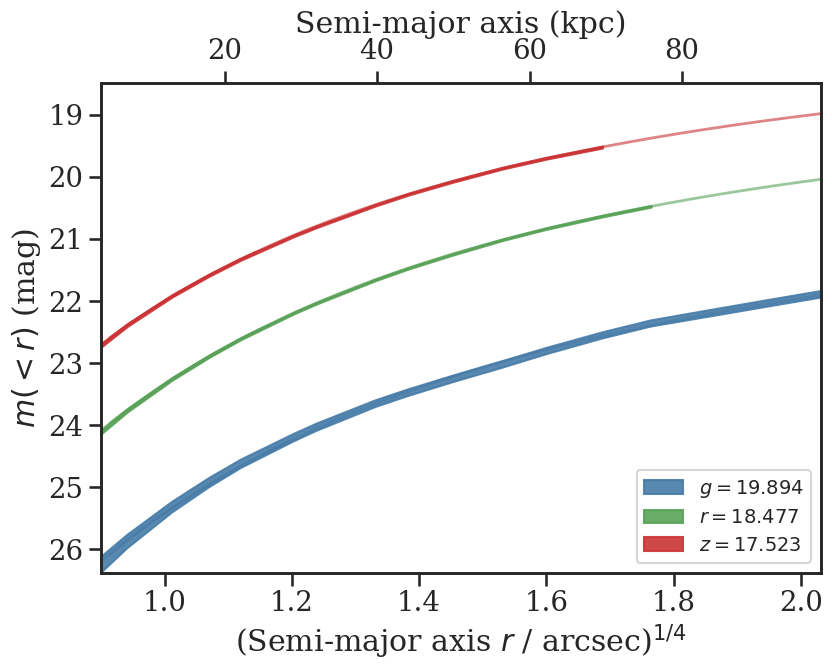

In [38]:
test_id = "39627865741856956"

ellipse_file = test_path + '/39627865741856956-custom-ellipse-39627865741856956.fits'

qa_curveofgrowth(ellipse_file, cosmo=cosmo)